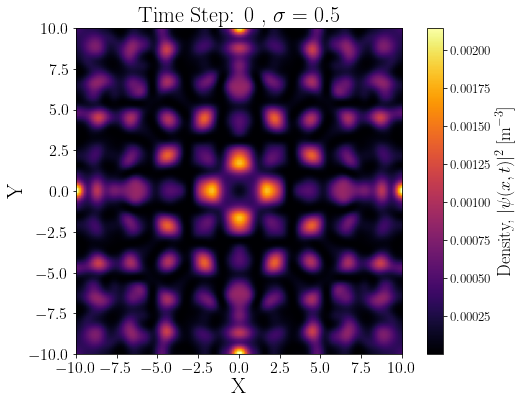

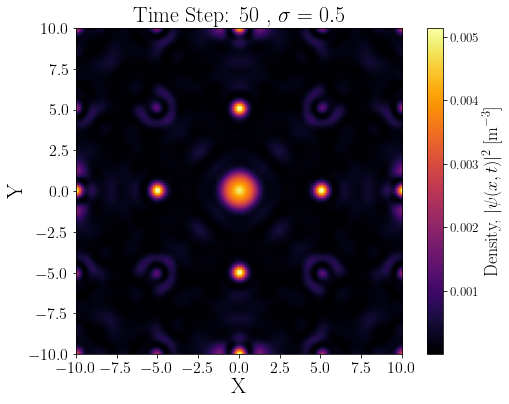

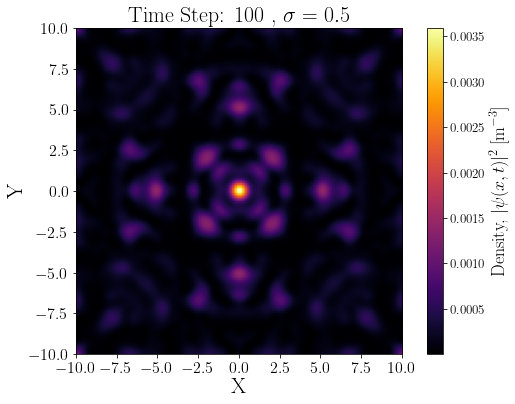

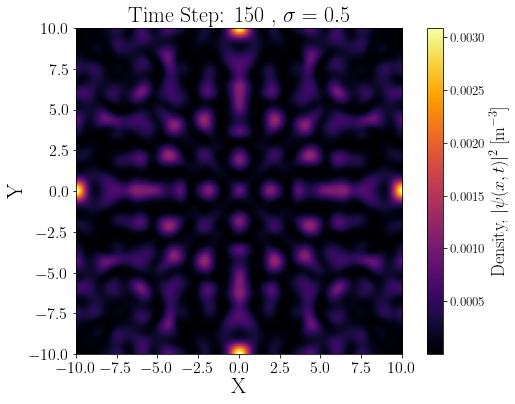

Maximum value of density: 5.2900e-03
Minimum value of density: 5.8618e-11


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftn, ifftn, fftfreq
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


#Solution of SP equation for FDM only using Gaussian density profile as an 
# initial wave function.

π = np.pi
Ω_cdm = 0.85
c = 3e8               #in units of m/s
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg

h_bar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg



L = 20.0               # size of the 3D simulation box
N = 128                # grid size
dx = L / N             # spatial resolution of the grid
dt = 0.01              # step size for time evolution
steps = 200           # number of time steps

# Spatial grid
x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
z = np.linspace(-L/2, L/2, N)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
R = np.sqrt(X**2 + Y**2 + Z**2)

# initial wavefunction assumed to be as Gaussian 
sigma = 0.5  #selected as per choice 
psi =  (1/np.sqrt(2 * np.pi * (sigma**2))) * np.exp(-(R**2)/(2 * (sigma**2)))
psi /= np.sqrt(np.sum(np.abs(psi)**2) * (dx**3))  # normalization expression


# spatial grid in 3D Fourier space
k_x = fftfreq(N, d=dx) * 2 * np.pi
k_y = fftfreq(N, d=dx) * 2 * np.pi
k_z = fftfreq(N, d=dx) * 2 * np.pi
K_X, K_Y, K_Z = np.meshgrid(k_x, k_y, k_z, indexing='ij')
K_2 = (K_X**2) + (K_Y**2) + (K_Z**2)

def gravitational_potential(psi):
    density = np.abs(psi)**2
    density_ft = fftn(density)
    b = 1e-6
    phi_ft = -4 * np.pi * G * density_ft/(K_2 + b) 
    phi = np.real(ifftn(phi_ft))
    return phi





# Time evolution of wave function and the desnity
for step in range(steps):
    phi_FDM = gravitational_potential(psi)
    V = m_FDM * phi_FDM
    psi = psi * np.exp(-(0.5j * V * dt)/h_bar)
    psi_ft = fftn(psi)
    psi_ft = psi_ft * np.exp(-(0.5j * h_bar * K_2 * dt)/(2 * m_FDM))
    psi = ifftn(psi_ft)
    psi = psi * np.exp((-0.5j * V * dt)/h_bar)
    psi /= np.sqrt(np.sum(np.abs(psi)**2) * (dx**3))
    if step % 50 == 0:
        fig, ax = plt.subplots(1, figsize=(9, 6))
        cax = ax.imshow(np.abs(psi[:, :, N//2])**2, extent=[-L/2, L/2, -L/2, L/2], cmap='inferno')
        cbar = fig.colorbar(cax)
        cbar.ax.tick_params(labelsize = 13)
        cbar.set_label(label=r'Density, $|\psi(x, t)|^{2}\, [\mathrm{m}^{-3}]$', size = 18)
        plt.title(f'Time Step: {step} , $\sigma = 0.5$', fontsize = 22)
        plt.xlabel('X', fontsize = 22, labelpad = 2)
        plt.ylabel('Y', fontsize = 22, labelpad = 2)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.savefig(f"density_noPBH_{step}.pdf", bbox_inches = 'tight') 
        plt.show()


final_density = (np.abs(psi)**2)
print('Maximum value of density:', '%0.4e'%np.max(final_density))
print('Minimum value of density:', '%0.4e'%np.min(final_density))
plt.show()

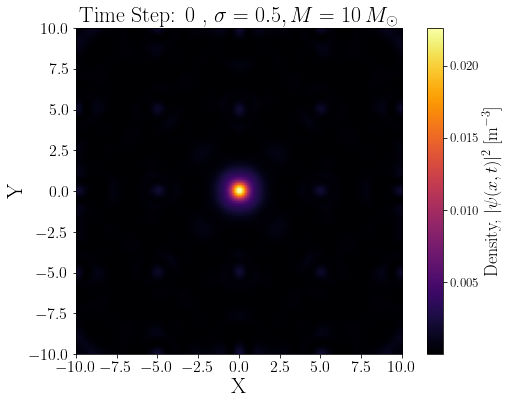

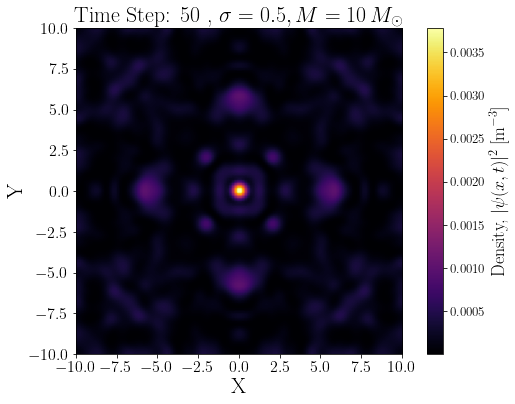

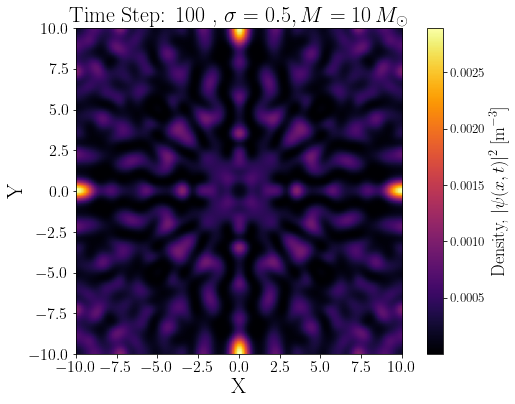

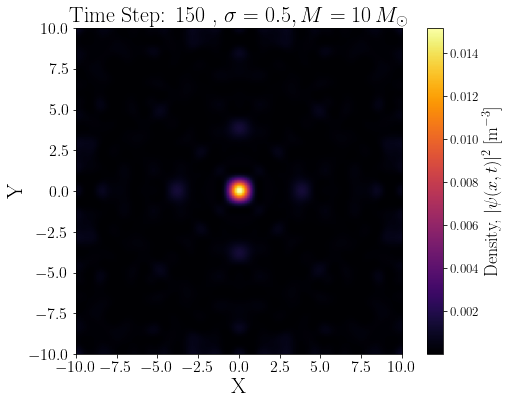

Maximum value of density: 8.2064e-03
Minimum value of density: 2.6721e-11


In [2]:
# Including the Gravitational potential of the PBH at the center at R = 0. 
M_pbh = 10 * M_solar
phi_pbh = -(G * M_pbh)/(0 + 1e-6)   # as phi_pbh = -GM_pbh/R


for step in range(steps):
    phi_FDM = gravitational_potential(psi)
    V = m_FDM * (phi_FDM + phi_pbh)  #total grviational potential of the system
    psi = psi * np.exp(-(0.5j * V * dt)/h_bar)
    psi_ft = fftn(psi)
    psi_ft = psi_ft * np.exp(-(0.5j * h_bar * K_2 * dt)/(2 * m_FDM))
    psi = ifftn(psi_ft)
    psi = psi * np.exp((-0.5j * V * dt)/h_bar)
    psi /= np.sqrt(np.sum(np.abs(psi)**2) * (dx**3))
    if step % 50 == 0:
        fig, ax = plt.subplots(1, figsize=(9, 6))
        cax = ax.imshow(np.abs(psi[:, :, N//2])**2, extent=[-L/2, L/2, -L/2, L/2], cmap='inferno')
        cbar = fig.colorbar(cax)
        cbar.ax.tick_params(labelsize = 13)
        cbar.set_label(label=r'Density, $|\psi(x, t)|^{2}\, [\mathrm{m}^{-3}]$', size = 18)
        plt.title(f'Time Step: {step} , $\sigma = 0.5, M = 10\, M_\odot$', fontsize = 22)
        plt.xlabel('X', fontsize = 22, labelpad = 2)
        plt.ylabel('Y', fontsize = 22, labelpad = 2)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.savefig(f"density_withPBH_{step}.pdf", bbox_inches = 'tight') 
        plt.show()


final_density = (np.abs(psi)**2)
print('Maximum value of density:', '%0.4e'%np.max(final_density))
print('Minimum value of density:', '%0.4e'%np.min(final_density))
plt.show()